In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from tools import *
from models import ContinuousReverseGame, ContinuousGameOfLife

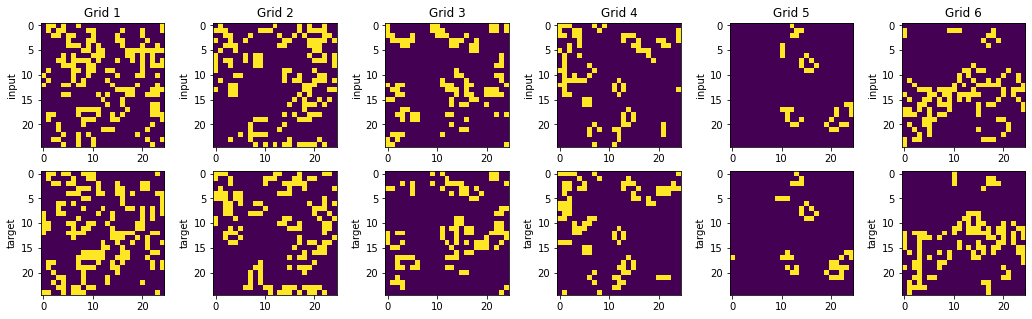

In [4]:
# generating some inputs and targets for the general mode

x, y = generate_input(trials=8, grid_shape=(25,25),steps_before_generating_output=5)


plt.figure(figsize=(3*len(x), 5))
for i in range(len(x)):
    plt.subplot(2, len(x), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(x[i])
    plt.ylabel('input')
    plt.subplot(2, len(x), len(x)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')    

In [74]:
k1 = tf.constant([[1,1,1],[1,0,1],[1,1,1]], dtype='float32')
k1 = tf.reshape(k1, shape=(3,3,1,1))
k2 = tf.constant([[0,0,0],[0,1,0],[0,0,0]], dtype='float32')
k2 = tf.reshape(k2, shape=(3,3,1,1))

def compute_loss(input_img, target):
    input_img[:,0,:].assign(input_img[:,-2,:])
    input_img[:,-1,:].assign(input_img[:,1,:])
    input_img[:,:,0].assign(input_img[:,:,-2])
    input_img[:,:,-1].assign(input_img[:,:,1])

    input_img = tf.reshape(input_img, shape=(1, l+2, l+2, 1))
    cell = tf.nn.conv2d(input_img, filters=k2, strides=1, padding='VALID')
    around_cell = tf.nn.conv2d(input_img, filters=k1, strides=1, padding='VALID')

    x1 = tf.maximum(4-around_cell,0)
    x2 = tf.maximum((around_cell + cell)-2,0)
    x3 = tf.minimum(x1, x2)
    x4 = tf.minimum(x3,1)

    x4 = tf.reshape(x4, shape=(l,l))
    y = tf.math.abs(x4-target)
    
    loss = tf.reduce_mean(y)
    return loss 

def compute_loss1(input_img, target):
    input_img[:,0,:].assign(input_img[:,-2,:])
    input_img[:,-1,:].assign(input_img[:,1,:])
    input_img[:,:,0].assign(input_img[:,:,-2])
    input_img[:,:,-1].assign(input_img[:,:,1])

    input_img = tf.reshape(input_img, shape=(1, l+2, l+2, 1))
    cell = tf.nn.conv2d(input_img, filters=k2, strides=1, padding='VALID')
    around_cell = tf.nn.conv2d(input_img, filters=k1, strides=1, padding='VALID')

    x1 = tf.maximum(4-around_cell,0)
    x2 = tf.maximum((around_cell + cell)-2,0)
    x3 = tf.minimum(x1, x2)
    x4 = tf.minimum(x3,1)

    x4 = tf.reshape(x4, shape=(l,l))
    y = tf.math.abs(x4-target)
    
    loss = tf.reduce_mean(y)
    loss1 =tf.reduce_mean(tf.math.abs(x4 - x4**2))
    return loss + 5*loss1



In [96]:
@tf.function
def gradient_ascent_step(img, target, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss1(img, target)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # grads = tf.multiply(grads, mask)
    # Normalize gradients.
    grads_normed = tf.math.l2_normalize(grads)
    img.assign_sub(grads_normed*learning_rate)
    return loss, img, grads_normed

In [97]:
M1, M2, M3, M4 = create_masks(27)

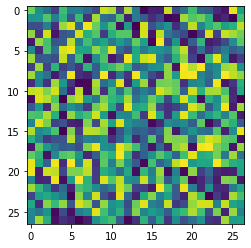

In [98]:
iterations = 4
learning_rate = 0.5
l = 25

img = tf.Variable(tf.random.uniform(shape=(1,l+2,l+2), minval=0.1, maxval=0.6), trainable=True, validate_shape=True)

# grid = tf.Variable(CyclicPadding2D()(y[1:2]))

# img = img + tf.Variable(tf.random.uniform(shape=(1,l+2,l+2), minval=-0.1, maxval=0.1), trainable=True, validate_shape=True)

plt.imshow(img[0])

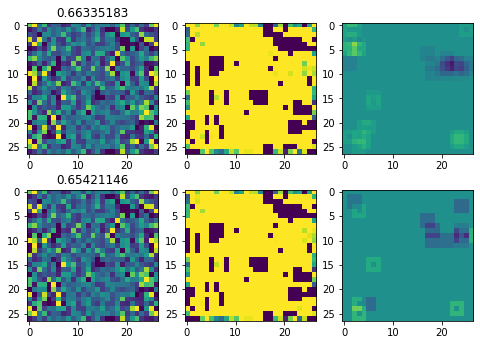

In [104]:
iterations = 2
plt.figure(figsize=(8, 3*4*iterations))


for i in range(200):
    loss, img , gr = gradient_ascent_step(img, y[1], 0.3)
    img = tf.Variable(img)

for i in range(iterations):
    loss, img , gr = gradient_ascent_step(img, y[1], 0.1)
    img = tf.Variable(img)
    plt.subplot(iterations*4,3, 3*i+1)
    plt.title(str(loss.numpy()))
    plt.imshow(img[0], vmin=0, vmax=1)
    plt.subplot(iterations*4, 3, 3*i+2)
    plt.imshow( game(img)[0], vmin=0, vmax=1)
    plt.subplot(iterations*4, 3, 3*i+3)
    plt.imshow( gr[0], vmin=-0.3, vmax=0.3)
        

    

In [32]:
img = tf.Variable(img)

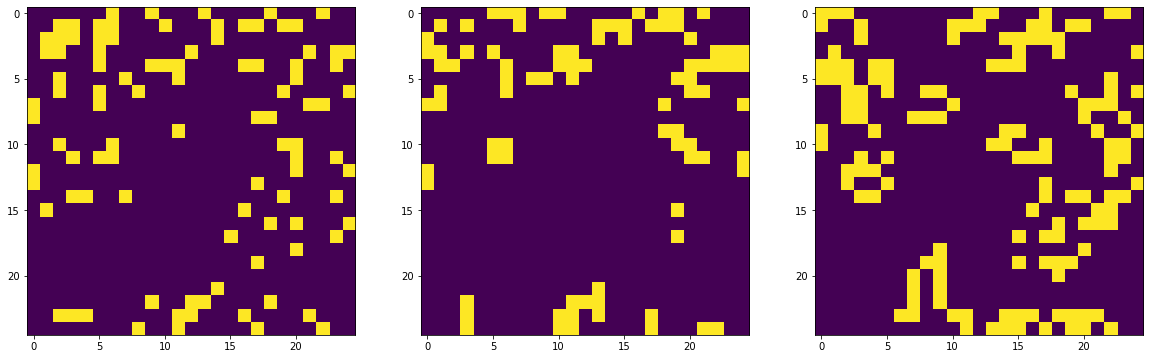

In [68]:
plt.figure(figsize=(20,10))

a = (img>0.97).numpy()*1.
plt.subplot(1, 3, 1)
plt.imshow(a[0][1:26,1:26] , vmin=0, vmax=1)
plt.subplot(1,3,2)
plt.imshow(game(a)[0][1:26,1:26], vmin=0, vmax=1)
plt.subplot(1, 3, 3)
plt.imshow(y[1], vmin=0, vmax=1)